In [7]:
# this is tutorial for HMC from their website
import torch
import numpy as np
import hamiltorch
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cpu')

In [3]:
def log_prob_func(params):
    mean = torch.tensor([1.,2.,3.])
    stddev = torch.tensor([0.5,0.5,0.5])
    return torch.distributions.Normal(mean, stddev).log_prob(params).sum()

In [4]:
num_samples = 400
step_size = .3
num_steps_per_sample = 5

hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
params_hmc = hamiltorch.sample(log_prob_func=log_prob_func,
                               params_init=params_init,  
                               num_samples=num_samples, 
                               step_size=step_size, 
                               num_steps_per_sample=num_steps_per_sample)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 400/400 | 539.78       
Acceptance Rate 0.99


In [27]:
# sample from normal distribution 
def normal_log(params):
    mean = torch.tensor([1,0])
    stddev = torch.tensor([0.5,1])
    return torch.distributions.Normal(mean, stddev).log_prob(params).sum()

In [32]:
# a now halmtorch can sample from normal distribution
num_samples = 1000
step_size = .1
num_steps_per_sample = 3

hamiltorch.set_random_seed(1)
params_init = torch.ones(2)
params_hmc = hamiltorch.sample(log_prob_func=normal_log,
                               params_init=params_init,  
                               num_samples=num_samples, 
                               step_size=step_size, 
                               num_steps_per_sample=num_steps_per_sample)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 1000/1000 | 680.76       
Acceptance Rate 1.00


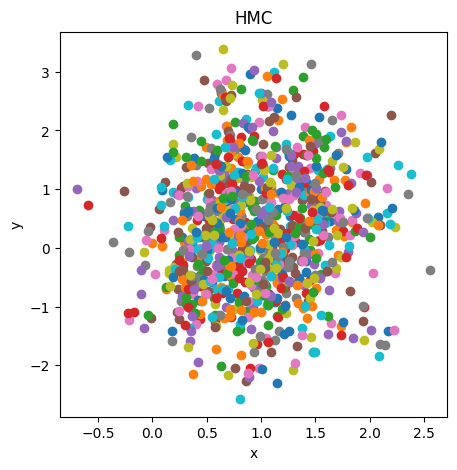

In [33]:
# plot the result
plt.figure(figsize=(5, 5))
for ii in range(len(params_hmc)):
    plt.plot(params_hmc[ii][0], params_hmc[ii][1], 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('HMC')
plt.show()

In [39]:
# for neural network 
def cubic_sin(x: torch.Tensor,
                 noise_std: float = 0.05) -> torch.Tensor:
    """forrestor function with noise"""

    obj =torch.sin(6*x)**3 + torch.randn_like(x) * noise_std

    return obj.reshape((-1, 1))

In [105]:
# generate samples 
# generate data
sample_x1 = torch.linspace(-0.8, -0.2, 17).reshape((-1, 1))
sample_x2 = torch.linspace(0.2, 0.8, 17).reshape((-1, 1))
sample_x = torch.cat([sample_x1, sample_x2], dim=0)
# sample_x = torch.linspace(0, 1, 8).reshape((-1, 1))
# print(sample_x)
sample_y = cubic_sin(sample_x, noise_std=0.1)

# test data
test_x = torch.linspace(-1, 1, 1000).reshape((-1, 1))
test_y = cubic_sin(test_x, noise_std=0.0)


In [106]:
sample_x.shape
sample_y.shape

torch.Size([34, 1])

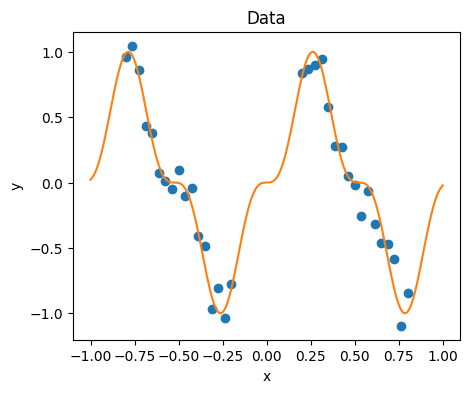

In [107]:
# plot the data
plt.figure(figsize=(5, 4))
plt.plot(sample_x.numpy(), sample_y.numpy(), 'o')
plt.plot(test_x.numpy(), test_y.numpy(), '-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')
plt.show()

In [108]:
# define a net 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(1, 50)
        self.fc2 = torch.nn.Linear(50, 50)
        self.fc3 = torch.nn.Linear(50, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x= torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [138]:
# prepare the for sampling
step_size = 0.001
num_samples = 1000
L = 50
burn = -1
store_on_GPU = False
debug = False
model_loss = 'regression'
mass = 1.0

# Effect of tau
# Set to tau = 1000. to see a function that is less bendy (weights restricted to small bends)
# Set to tau = 1. for more flexible

tau = 1.0 # Prior Precision
tau_out = 100 # Output Precision (Likelihood Precision), known noise 
r = 0 # Random seed


tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
    
tau_list = torch.tensor(tau_list).to(device)

# Set initial weights
params_init = hamiltorch.util.flatten(net).to(device).clone()
# Set the Inverse of the Mass matrix
inv_mass = torch.ones(params_init.shape) / mass

In [139]:
print(params_init.shape)
integrator = hamiltorch.Integrator.EXPLICIT
sampler = hamiltorch.Sampler.HMC

hamiltorch.set_random_seed(r)
params_hmc_f = hamiltorch.sample_model(net,sample_x.to(device), sample_y.to(device), params_init=params_init,
                                       model_loss=model_loss, num_samples=num_samples,
                                       burn = burn, inv_mass=inv_mass.to(device),step_size=step_size,
                                       num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list,
                                       debug=debug, store_on_GPU=store_on_GPU,
                                       sampler = sampler)

# At the moment, params_hmc_f is on the CPU so we move to GPU

params_hmc_gpu = [ll.to(device) for ll in params_hmc_f[1:]]



torch.Size([2701])
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec


In [134]:

# Let's predict over the entire test range [-2,2]
pred_list, log_probs_f = hamiltorch.predict_model(net, x = test_x.to(device),
                                                  y = test_y.to(device), samples=params_hmc_gpu,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)
# Let's evaluate the performance over the training data
pred_list_tr, log_probs_split_tr = hamiltorch.predict_model(net, x = sample_x.to(device), y=sample_y.to(device),
                                                            samples=params_hmc_gpu, model_loss=model_loss,
                                                            tau_out=tau_out, tau_list=tau_list)
ll_full = torch.zeros(pred_list_tr.shape[0])
ll_full[0] = - 0.5 * tau_out * ((pred_list_tr[0].cpu() - sample_y) ** 2).sum(0)
for i in range(pred_list_tr.shape[0]):
    ll_full[i] = - 0.5 * tau_out * ((pred_list_tr[:i].mean(0).cpu() - sample_y) ** 2).sum(0)

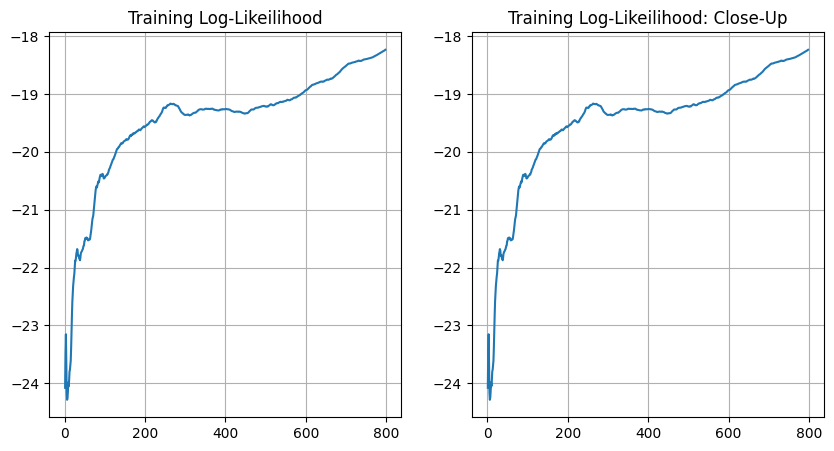

In [135]:
# plot nll 
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.set_title('Training Log-Likeilihood')
ax1.plot(ll_full)
ax1.grid()

ax2.set_title('Training Log-Likeilihood: Close-Up')
ax2.plot(ll_full)
# ax2.set_ylim([-120,-80])
ax2.grid()
plt.show()

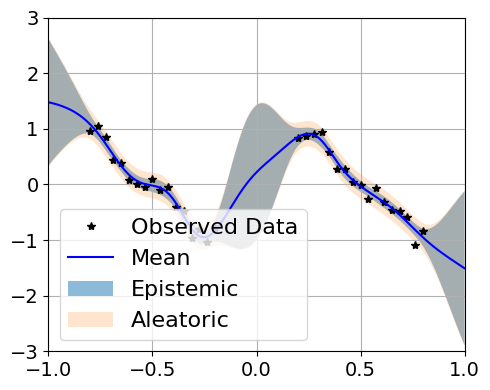

In [137]:
fs = 16

m = pred_list[0:].mean(0).to('cpu')
s = pred_list[0:].std(0).to('cpu')
s_al = (pred_list[0:].var(0).to('cpu') + tau_out ** -1) ** 0.5
m.shape, s.shape

f, ax = plt.subplots(1, 1, figsize=(5, 4))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(sample_x.numpy(), sample_y.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(test_x.numpy(), m.numpy(), 'b', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(test_x.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
ax.set_ylim([-3, 3])
ax.set_xlim([-1, 1])
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

bbox = {'facecolor': 'white', 'alpha': 0.8, 'pad': 1, 'boxstyle': 'round', 'edgecolor':'black'}
# plt.text(1., -1.5, 'Acceptance Rate: 58 %', bbox=bbox, fontsize=16, horizontalalignment='center')


plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

torch.Size([1000, 1])

In [125]:
len(pred_list)

10000

In [1]:
from enum import Enum
class Sampler(Enum):
    HMC = 1
    RMHMC = 2
    HMC_NUTS = 3
    # IMPORTANCE = 3
    # MH = 4


In [2]:
sam = Sampler.HMC

In [5]:
sam.value

1